In [1]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.datasets import VOCDetection
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
# Custom Dataset wrapper for VOC
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, root, year='2007', image_set='train', transforms=None):
        self.dataset = VOCDetection(root, year=year, image_set=image_set, download=True)
        self.transforms = transforms

    def __getitem__(self, idx):
        img, target = self.dataset[idx]
        img = F.to_tensor(img)

        boxes = []
        labels = []
        for obj in target['annotation']['object']:
            bbox = obj['bndbox']
            xmin = float(bbox['xmin'])
            ymin = float(bbox['ymin'])
            xmax = float(bbox['xmax'])
            ymax = float(bbox['ymax'])
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(VOC_CLASSES.index(obj['name']))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {'boxes': boxes, 'labels': labels}

        return img, target

    def __len__(self):
        return len(self.dataset)

In [3]:
# Pascal VOC classes
VOC_CLASSES = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor'
]

In [4]:
# Data loading
train_dataset = VOCDataset(root='.', year='2007', image_set='train')
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))


100%|██████████| 460M/460M [00:18<00:00, 25.0MB/s]


In [5]:
# Model: Faster R-CNN with ResNet-50 + FPN
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.train()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 168MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [6]:
# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [7]:
# Training loop
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

for epoch in range(10):
    for images, targets in train_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {losses.item():.4f}")

Epoch 1, Loss: 0.1018
Epoch 2, Loss: 0.2479
Epoch 3, Loss: 0.1656
Epoch 4, Loss: 0.2326
Epoch 5, Loss: 0.1984
Epoch 6, Loss: 0.2079
Epoch 7, Loss: 0.4879
Epoch 8, Loss: 0.3140
Epoch 9, Loss: 0.1819
Epoch 10, Loss: 0.4016


In [8]:
# Save the trained model
torch.save(model.state_dict(), "fasterrcnn_resnet50_voc.pth")

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image


In [10]:
# Function to draw bounding boxes
def draw_boxes(img, boxes, labels, scores=None, threshold=0.5):
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img.permute(1, 2, 0).cpu())

    for i, box in enumerate(boxes):
        if scores is not None and scores[i] < threshold:
            continue
        x_min, y_min, x_max, y_max = box
        label = VOC_CLASSES[labels[i]]
        color = 'red'
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        text = f"{label} ({scores[i]:.2f})" if scores is not None else label
        ax.text(x_min, y_min - 5, text, color='white', backgroundcolor='red', fontsize=10)

    plt.axis('off')
    plt.show()

In [11]:
# Load a few test samples
test_dataset = VOCDataset(root='.', year='2007', image_set='val')
idx = random.randint(0, len(test_dataset)-1)
img, target = test_dataset[idx]
img_input = img.to(device).unsqueeze(0)

In [12]:
# Run inference
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    prediction = model(img_input)[0]

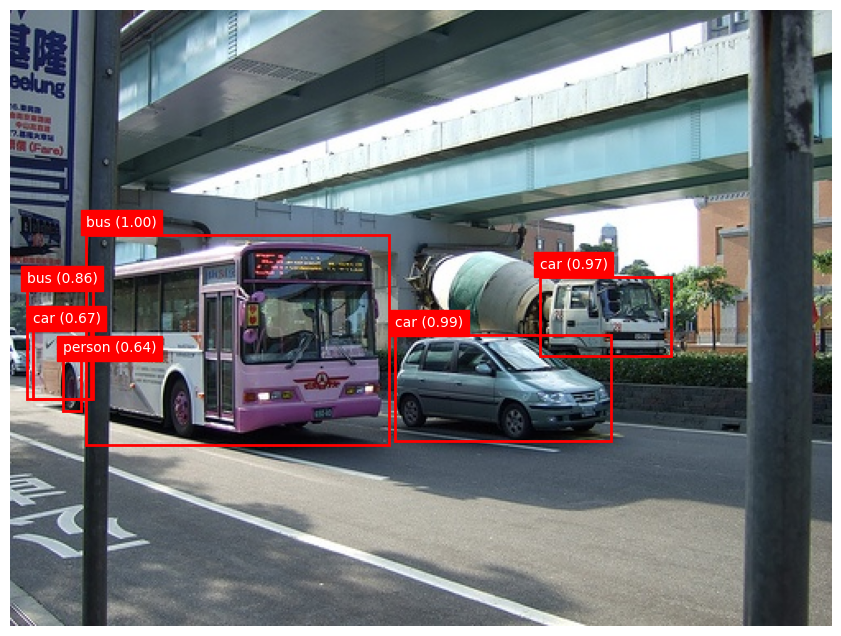

In [14]:
# Visualize results
draw_boxes(img, prediction['boxes'].cpu(), prediction['labels'].cpu(), prediction['scores'].cpu())

In [26]:
from torchvision.ops import box_iou

def evaluate_model(model, dataset, iou_threshold=0.5, score_threshold=0.5, num_samples=50):
    model.eval()
    model.to(device)

    total_tp, total_fp, total_fn = 0, 0, 0
    aps = []

    for i in range(min(num_samples, len(dataset))):
        img, target = dataset[i]
        img_input = img.to(device).unsqueeze(0)

        with torch.no_grad():
            prediction = model(img_input)[0]

        pred_boxes = prediction['boxes'][prediction['scores'] > score_threshold].cpu()
        pred_labels = prediction['labels'][prediction['scores'] > score_threshold].cpu()
        gt_boxes = target['boxes']
        gt_labels = target['labels']

        if len(pred_boxes) == 0:
            total_fn += len(gt_boxes)
            continue

        ious = box_iou(pred_boxes, gt_boxes)
        matched_gt = set()
        tp = 0

        for i in range(len(pred_boxes)):
            max_iou = 0
            max_j = -1
            for j in range(len(gt_boxes)):
                if j in matched_gt:
                    continue
                iou = ious[i, j].item()
                if iou > iou_threshold and iou > max_iou:
                    max_iou = iou
                    max_j = j
            if max_j >= 0:
                matched_gt.add(max_j)
                tp += 1

        fp = len(pred_boxes) - tp
        fn = len(gt_boxes) - tp

        total_tp += tp
        total_fp += fp
        total_fn += fn


    precision = total_tp / (total_tp + total_fp + 1e-6)
    recall = total_tp / (total_tp + total_fn + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    print(f"Simple mAP (1 class): {precision:.4f}")

In [29]:
print("Testing evaluation function...")
evaluate_model(model, test_dataset, score_threshold=0.5, num_samples=100)


Testing evaluation function...
Precision: 0.5245, Recall: 0.7475, F1: 0.6164
Simple mAP (1 class): 0.5245


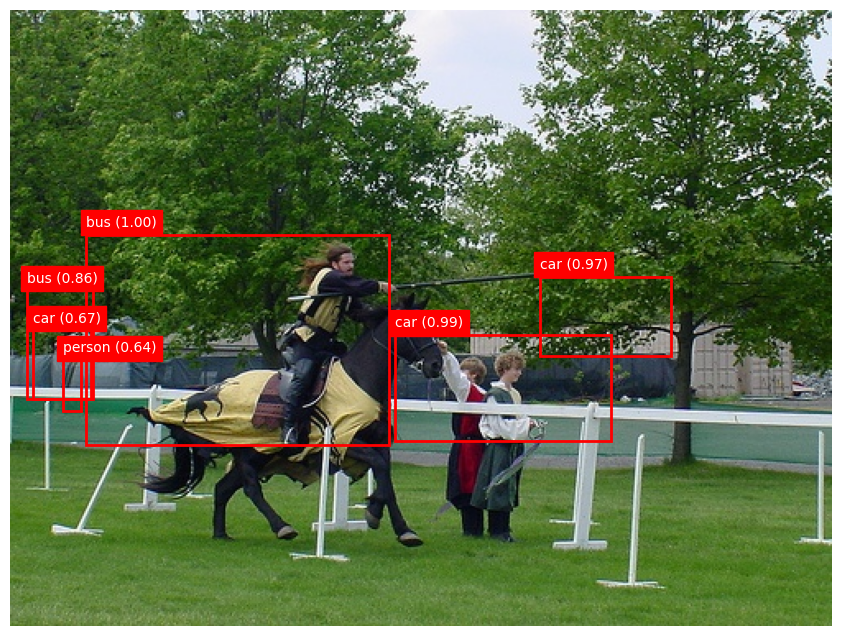

In [31]:

draw_boxes(img, prediction['boxes'].cpu(), prediction['labels'].cpu(), prediction['scores'].cpu())


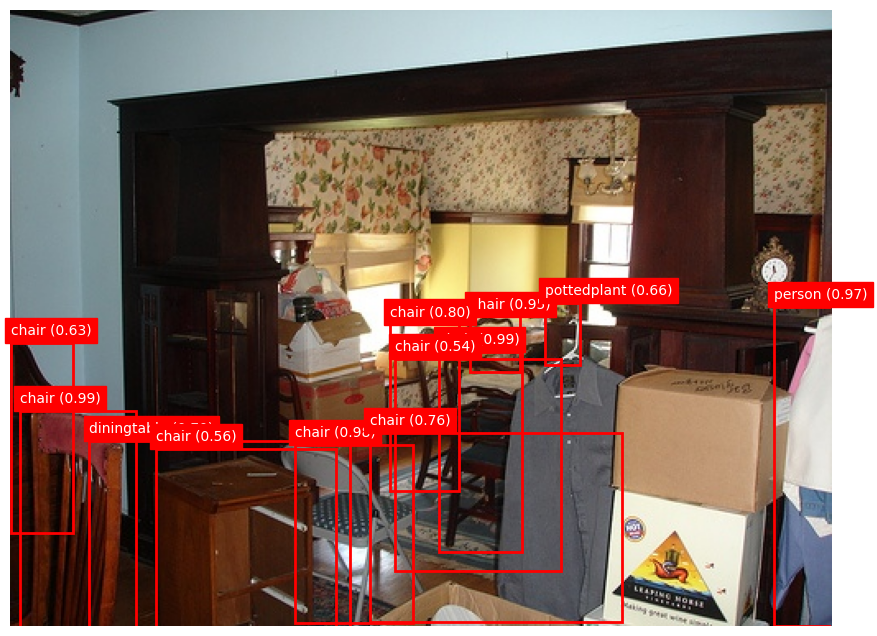

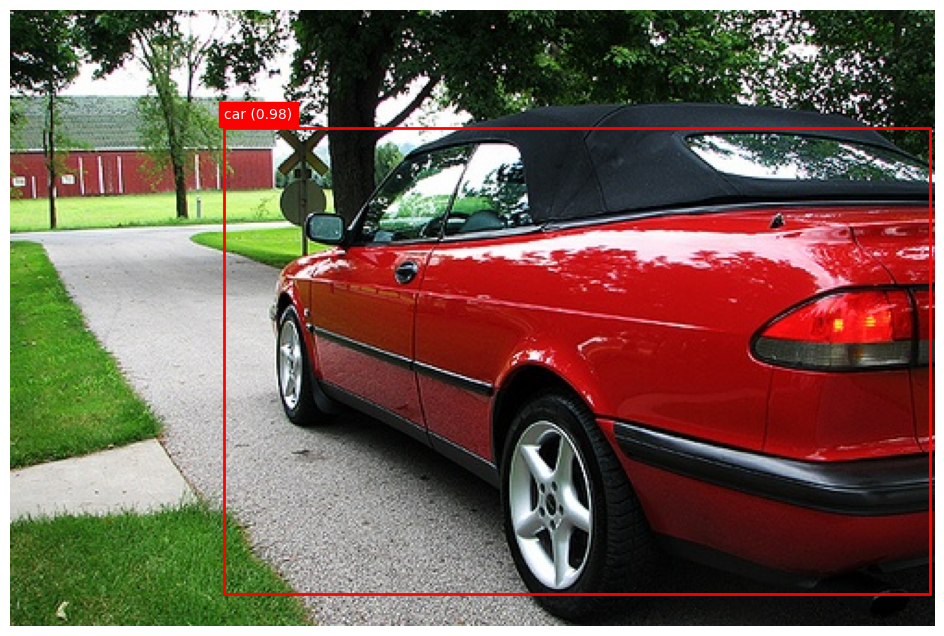

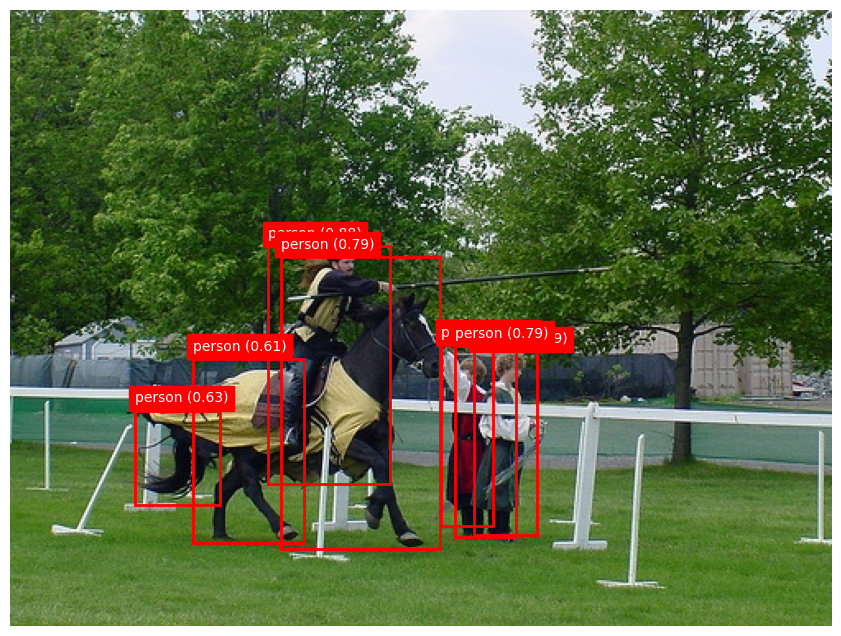

In [18]:
for i in range(3):  # Showing 3 test examples
    img, _ = test_dataset[i]
    img_input = img.to(device).unsqueeze(0)
    with torch.no_grad():
        pred = model(img_input)[0]
    draw_boxes(img, pred['boxes'].cpu(), pred['labels'].cpu(), pred['scores'].cpu())